<img src="Bases/logoMoSEF.jpeg" width="90px" align="left">
<div align="right">Enseignant : Nexialog</div>
<div align="right">Réalisé par : Seçil Coskun, ABABII Anisoara, Eunice KOFFI et DIAKITE Gaoussou</div>
<div align="right">Année : 2022/2023</div><br><br><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen">Master 2 Modélisation Statistiques Economiques et Financières</span></div><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen">Université Paris 1 Panthéon-Sorbonne</span></div><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:28px;color:#e60000">Challenge Nexialog</span></div><br><br>
<hr>

<p>Le risque de crédit est un enjeu majeur pour les institutions financières, qui doivent s'assurer de la solvabilité de leurs clients afin de minimiser les pertes liées aux défauts de paiement. Dans ce contexte, la construction d'un modèle économétrique permettant de prédire le taux de défaut à partir de variables macroéconomiques constitue un enjeu crucial. Ce modèle doit être capable d'identifier les facteurs économiques qui peuvent influencer la probabilité de défaut, et de les intégrer dans une analyse quantitative qui permettra de déterminer le niveau de risque associé à chaque client. Dans le cadre de ce challenge, nous disposons de plusieurs bases de données contenant des informations sur les variables macroéconomiques, ainsi que des séries de taux de passage en défaut. En utilisant des modèles économétriques basiques et des modèles de machine learning, nous chercherons à développer des prévisions fiables du taux de défaut, en utilisant des scénarios baseline et adverse pour simuler des situations économiques différentes. Le résultat de ce projet sera présenté sous forme d'interface utilisateur, utilisant le framework Streamlit, afin de faciliter l'analyse et la présentation des résultats obtenus.</p>

><div class="alert alert-block alert-success">
<b>L'objectif de ce challenge</b> est alors de Construire d’une série de taux de défaut (𝐷𝑅_𝑡) et d’un modèle économétrique reliant le taux de défaut aux variables macroéconomiques.</div>



<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px;color:darkgreen"> <span style="color:green">      
IMPORTATION DES LIBRAIRIES</span>

In [1]:
import warnings
import pandas as pd
import numpy as np
from sas7bdat import SAS7BDAT
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
%matplotlib inline
from arch.unitroot import PhillipsPerron
from scipy.stats import kendalltau
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from typing import List
from statsmodels.tsa.stattools import adfuller, kpss 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import kendalltau
from scipy.stats import levene
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_white
import itertools
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px;color:darkgreen"> <span style="color:green">      
IMPORTATION DES DONNEES</span>

In [2]:
date_q = pd.read_excel('Bases/date_quarterly.xlsx')
default_rate = pd.read_excel('Bases/default_rate_quarterly.xlsx', index_col='Date')
var_macro_adverse = pd.read_excel('Bases/variables_macroeconomiques_adverse.xlsx', index_col='Date')
var_macro = pd.read_excel('Bases/variables_macroeconomiques.xlsx', index_col='Date')
var_macro_baseline = pd.read_excel('Bases/variables_macroeconomiques_baseline.xlsx',index_col='Date')

<hr style="border-width:2px;border-color:green">
<center><h1>Présentation des données</h1></center>
<hr style="border-width:2px;border-color:green">

<html>
  <body>
    <p>Dans le cadre de ce projet, nous disposons de plusieurs bases de données contenant des variables macroéconomiques qui seront utilisées pour développer notre modèle de prédiction du taux de défaut. Chacune de ces bases de données contient des séries chronologiques pour les variables suivantes :</p>
    <ul>
      <li><b>RGDP :</b> Le Produit Intérieur Brut réel (PIB) représente la valeur totale de tous les biens et services finaux produits dans un pays donné pendant une période donnée. Cette variable est un indicateur clé de la santé économique d'un pays. Elle peut influencer le taux de défaut, car une économie forte peut signifier un marché du travail plus solide et une augmentation des revenus pour les emprunteurs, ce qui peut réduire le risque de défaut de paiement.</li>
      <li><b>HICP :</b> L'Indice Harmonisé des Prix à la Consommation (IHPC) mesure les variations du coût des biens et services couramment achetés par les ménages. Cette variable est un indicateur important de l'inflation, qui peut avoir un impact significatif sur la santé économique d'un pays et le taux de défaut. En effet, une inflation élevée peut rendre les coûts d'emprunt plus élevés, ce qui peut augmenter le risque de défaut.</li>
      <li><b>RREP :</b> Le Revenu disponible brut des ménages représente la somme totale de tous les revenus et prestations sociales dont les ménages disposent pour consommer ou épargner. Cette variable peut influencer le taux de défaut car elle peut être utilisée comme une mesure de la solvabilité des emprunteurs. Des revenus disponibles plus élevés peuvent indiquer une capacité de remboursement plus élevée pour les emprunteurs.</li>
      <li><b>IRLT :</b> Les taux d'intérêt à long terme représentent le coût du crédit à long terme pour les emprunteurs, tels que les prêts hypothécaires et les obligations. Cette variable peut influencer le taux de défaut car des taux d'intérêt plus élevés peuvent rendre le coût du crédit plus élevé pour les emprunteurs, ce qui peut augmenter le risque de défaut de paiement.</li>
      <li><b>UNR :</b> Le taux de chômage représente la proportion de la population active qui n'a pas d'emploi et qui cherche activement du travail. Cette variable peut influencer le taux de défaut car le chômage peut affecter la solvabilité des emprunteurs. En effet, les emprunteurs qui perdent leur emploi peuvent avoir des difficultés à rembourser leur dette, ce qui peut augmenter le risque de défaut de paiement.</li>
    </ul>
    <p>En résumé, ces variables macroéconomiques sont importantes pour prédire le taux de défaut, car elles peuvent fournir des informations sur la santé économique d'un pays et la solvabilité des emprunteurs. L'utilisation de séries chronologiques pour chaque variable nous permettra d'analyser les tendances et les modèles de comportement au fil du temps, ce qui nous permettra de développer

<!DOCTYPE html>
<html>
<head>
	
</head>
<body>
	<h1>Taux de défaut</h1>
	<table>
		<thead>
			<tr>
				<th>DR</th>
				<th>Date</th>
			</tr>
		</thead>
		<tbody>
			<tr>
				<td>0.059661</td>
				<td>2010-01-31</td>
			</tr>
			<tr>
				<td>0.049995</td>
				<td>2010-04-30</td>
			</tr>
			<tr>
				<td>0.049434</td>
				<td>2010-07-31</td>
			</tr>
			<tr>
				<td>0.049466</td>
				<td>2010-10-31</td>
			</tr>
			<tr>
				<td>0.047990</td>
				<td>2011-01-31</td>
			</tr>
		</tbody>
	</table>
	<h1>Var macro</h1>
	<table>
		<thead>
			<tr>
				<th>RGDP</th>
				<th>HICP</th>
				<th>RREP</th>
				<th>IRLT</th>
				<th>UNR</th>
				<th>Date</th>
			</tr>
		</thead>
		<tbody>
			<tr>
				<td>394004.0</td>
				<td>91.3</td>
				<td>119.18</td>
				<td>4.36</td>
				<td>7.589134</td>
				<td>2009-01-31</td>
			</tr>
			<tr>
				<td>396296.5</td>
				<td>90.6</td>
				<td>119.36</td>
				<td>4.37</td>
				<td>8.103871</td>
				<td>2009-04-30</td>
			</tr>
			<tr>
				<td>397582.5</td>
				<td>91.8</td>
				<td>118.59</td>
				<td>4.10</td>
				<td>8.280931</td>
				<td>2009-07-31</td>
			</tr>
			<tr>
				<td>398648.8</td>
				<td>90.7</td>
				<td>116.80</td>
				<td>4.08</td>
				<td>8.497120</td>
				<td>2009-10-31</td>
			</tr>
			<tr>
				<td>401628.8</td>
				<td>92.9</td>
				<td>117.90</td>
				<td>4.00</td>
				<td>8.612495</td>
				<td>2010-01-31</td>
			</tr>
		</tbody>
	</table


<hr style="border-width:2px;border-color:green">
<center><h1>Analyse exploratoire des données</h1></center>
<hr style="border-width:2px;border-color:green">

L'analyse exploratoire des données est une étape cruciale pour comprendre et interpréter les tendances macroéconomiques. Dans cette partie, nous allons étudier les données de manière graphique et statistique afin de détecter d'éventuels comportements inappropriés.

Nous allons commencer par visualiser les tendances de chaque variable macroéconomique à l'aide de graphiques.

Si nous trouvons des comportements inappropriés d'une date à une autre, nous allons utiliser des techniques appropriées pour corriger les tendances inappropriées, telles que les méthodes de lissage ou les techniques de désaisonnalisation.

Enfin, nous allons conclure notre analyse exploratoire des données en présentant les principales tendances macroéconomiques et les relations entre les différentes variables. Ces résultats nous aideront à mieux comprendre les tendances macroéconomiques et à les intégrer dans notre analyse de modélisation.

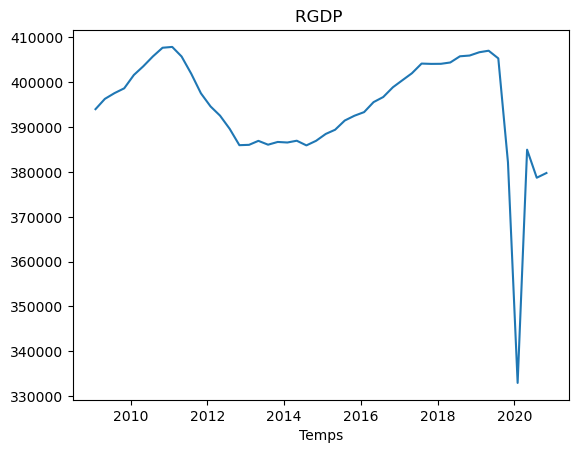

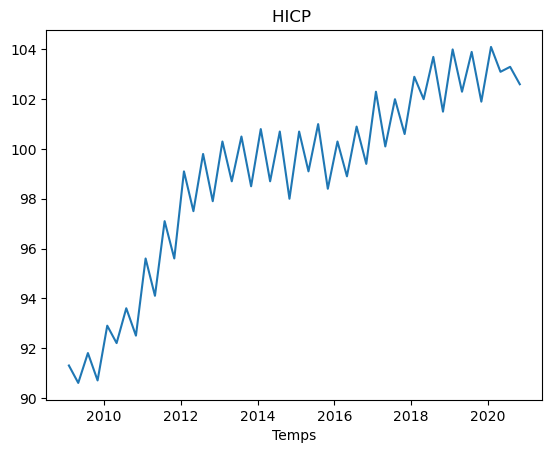

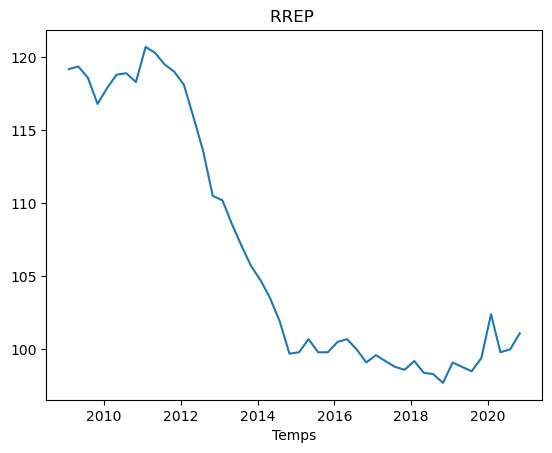

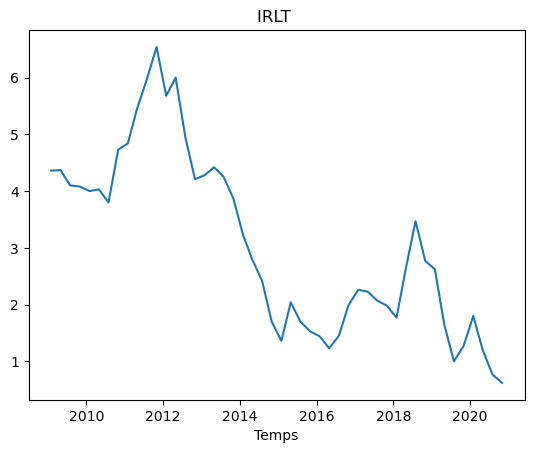

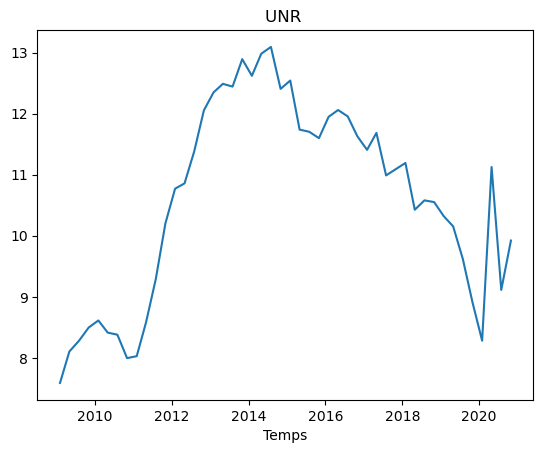

In [3]:
def graphiques(df):
    for column in df.columns:    
        ts = df[column]
        plt.plot(ts)
        plt.title('{} '.format(column))
        plt.xlabel('Temps')
        plt.show()
        
graphiques(var_macro)

### Commentaire

<p>Après avoir effectué l'analyse exploratoire des données, nous avons constaté des comportements inappropriés pour certaines variables macro-économiques, notamment des chutes brutales et des fluctuations importantes. Pour corriger ces tendances, nous avons décidé d'appliquer une méthode de lissage. Avant d'opter pour une technique de lissage appropriée:</p>
<ul>
  <li>Nous allons vérifier la stabilité de la variance de notre série avec trois outils différents.</li>
  <li>Nous allons également réaliser un test de Levene pour évaluer l'égalité de variance entre deux parties de notre série temporelle. L'hypothèse nulle de ce test était que les variances étaient égales.</li>
  <li>Enfin, nous allons effectuer un test de racine unitaire en calculant la variance sur des fenêtres glissantes de taille 4.</li>
</ul>
<p>En conclusion, nous avons constaté que les tests de stabilité de variance et de Levene ont confirmé les comportements inappropriés observés visuellement. Par conséquent, nous avons opté pour une méthode de lissage appropriée pour corriger les tendances inappropriées dans nos données. Nous avons également utilisé des tests statistiques pour nous assurer de l'égalité de variance entre les parties de notre série temporelle.</p>


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Visualition graphique de la statbilité de la variance de nos séries</span>

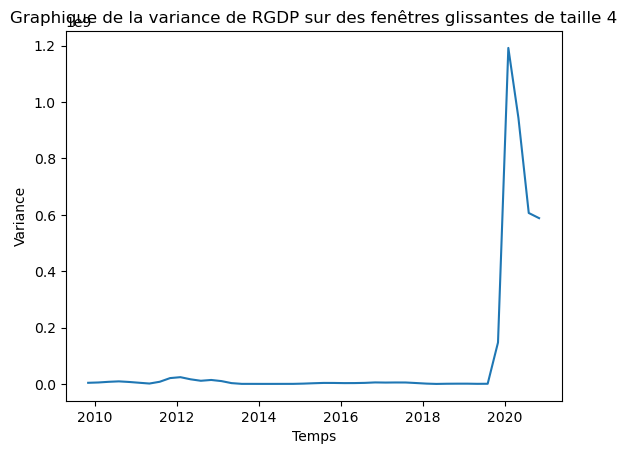

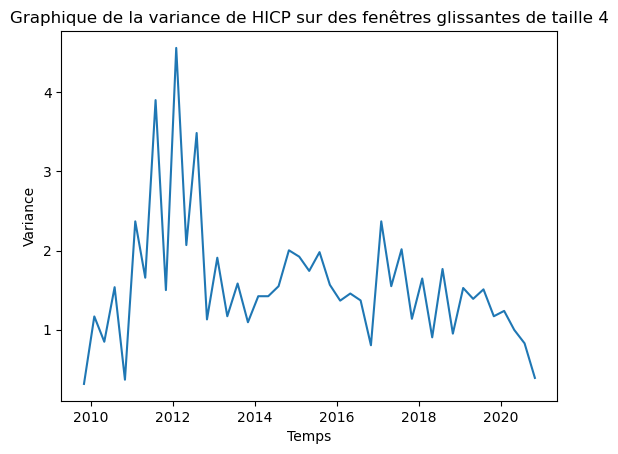

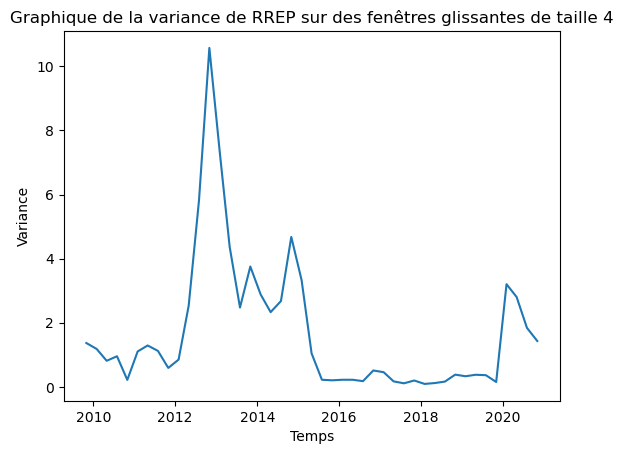

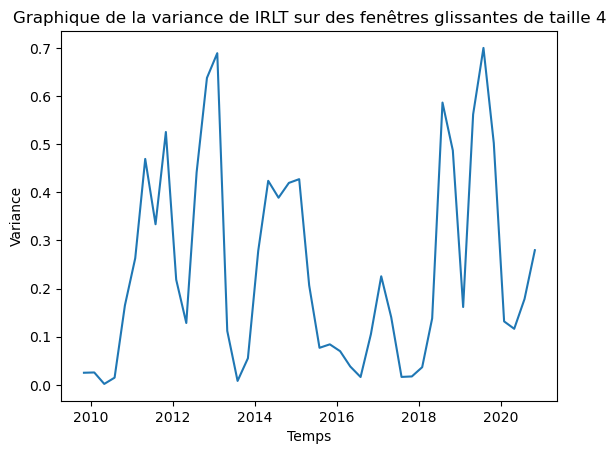

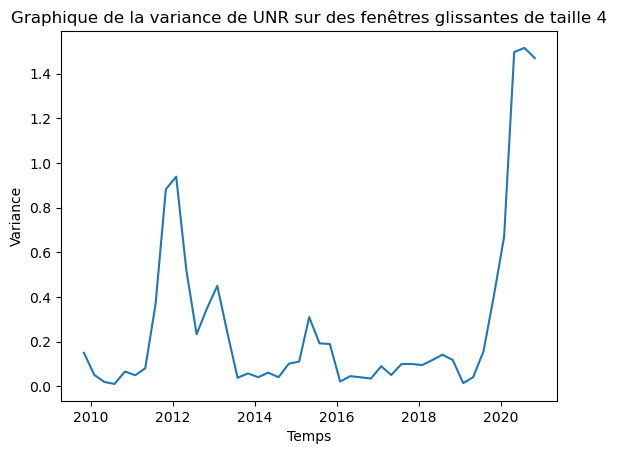

In [4]:
for column in var_macro.columns:    
    
    ts = var_macro[column]


    # Calcule la variance sur des fenêtres glissantes de taille 4
    rolling_var = ts.rolling(window=4).var()

    # Trace le graphique de la variance
    plt.plot(rolling_var)
    plt.title('Graphique de la variance de {} sur des fenêtres glissantes de taille 4'.format(column))
    plt.xlabel('Temps')
    plt.ylabel('Variance')
    plt.show()

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Test de Levene</span>

Pour confirmer ce que nous constatons visuellement, on réalise un test de Levene.
Ce test permet d'évaluer l'égalité de variance pour une variable calculée pour plusieurs groupes. On peut ainsi couper notre série temporelle en deux et tester l'égalite de variance entre la première et la deuxième partie.
Hypothèse nulle : les variances sont égales. 

In [5]:
def test_levene(df):
    variances_non_cstt = []
    for column in df.columns:    
        ts = df[column]

        # Calcule la variance sur des fenêtres glissantes de taille 4
        rolling_var = ts.rolling(window=4).var()
        rolling_var_without_na = rolling_var.dropna()
        middle_index = len(rolling_var_without_na) // 2
        premiere_partie = rolling_var_without_na.iloc[0:middle_index]
        deuxieme_partie = rolling_var_without_na.iloc[middle_index+1:]
        statistic, pvalue = levene(premiere_partie, deuxieme_partie)
        print("Pour la variable {} :".format(column))
        print("Statistique de test :", statistic)
        print("Valeur p :", pvalue, "\n")
        if pvalue < 0.05:
            variances_non_cstt.append(column)
    return "Nous pouvons utiliser la méthode de lissage MM exponentielle pour ces séries :", variances_non_cstt
    
test_levene(var_macro)

Pour la variable RGDP :
Statistique de test : 4.388421068592101
Valeur p : 0.0422542325788205 

Pour la variable HICP :
Statistique de test : 3.401669818594947
Valeur p : 0.07219143463938159 

Pour la variable RREP :
Statistique de test : 9.178056352623145
Valeur p : 0.004179047892918978 

Pour la variable IRLT :
Statistique de test : 0.6805889820364325
Valeur p : 0.4140451263313194 

Pour la variable UNR :
Statistique de test : 0.6541957062302027
Valeur p : 0.4231748066388532 



('Nous pouvons utiliser la méthode de lissage MM exponentielle pour ces séries :',
 ['RGDP', 'RREP'])

### Commentaire 

Après avoir effectué le test de Levene sur nos variables, nous avons obtenu un résultat indiquant une instabilité de la variance pour les variables RGDP et RREP. Cela signifie que l'hypothèse nulle de variance constante peut être rejetée au seuil de 5% pour ces variables. Cependant, nous avons également remarqué que l'utilisation de la méthode de lissage MM exponentielle pour ces variables conduirait à des séries non stationnaires. Étant donné que le lissage est considéré comme une perte d'information, nous avons décidé de ne plus appliquer cette méthode sur RGDP et RREP.

À la place, nous avons choisi d'utiliser la méthode de lissage sur la variable HICP, qui montre une forte fluctuation. Cette décision a été prise pour éviter de perdre des informations importantes et pour obtenir des résultats plus précis.

Il convient de noter que le choix de la méthode de lissage dépend des caractéristiques des données et des objectifs de l'analyse. Dans ce cas précis, nous avons décidé de ne pas appliquer le lissage sur RGDP et RREP en raison des risques de non-stationnarité, tout en l'appliquant sur HICP pour mieux comprendre les tendances de cette variable.


<hr style="border-width:2px;border-color:green">
<center><h1>Preprocessing</h1></center>
<hr style="border-width:2px;border-color:green">

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Lissage</span>

La méthode de lissage par moyenne mobile est une technique courante utilisée pour lisser les séries temporelles. Elle consiste à prendre une moyenne mobile d'une série temporelle sur une fenêtre de temps donnée pour en réduire les fluctuations et rendre les tendances plus apparentes.

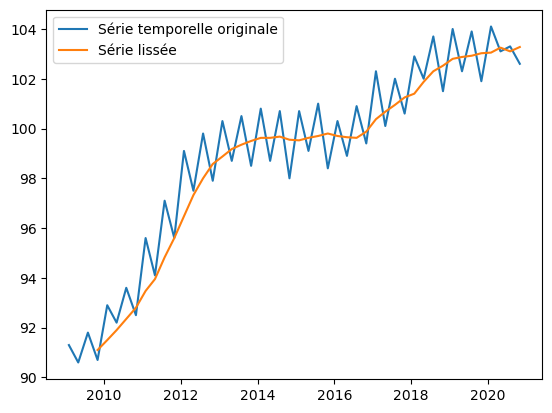

In [6]:
def lissage_mm(df, cols):
    for col in cols:
        ts = df[col]
        # Calculer la moyenne mobile avec une fenêtre de taille 4
        rolling_mean = ts.rolling(window=4).mean()
        df['{}_lissee'.format(col)] = rolling_mean

        # Tracer la série temporelle originale et la série lissée
        plt.plot(ts, label='Série temporelle originale')
        plt.plot(rolling_mean, label='Série lissée')
        plt.legend()
        plt.show()
    return df

var_macro = lissage_mm(var_macro, ["HICP"])

On supprime la série HICP originale, pour la suite de ce projet on utiliséra la version lissée

In [7]:
var_macro = var_macro.drop(["HICP"], axis = 1) 

### Commentaire 

Après avoir appliqué la technique de lissage par moyenne mobile sur la série HICP, nous avons pu constater que les évolutions générales des séries n'ont pas été altérées, mais que les fluctuations successives ont été lissées. Cette technique est l'une parmi d'autres méthodes de lissage, et une autre technique que nous aurions pu utiliser est la moyenne mobile pondérée exponentielle (EWMA). Cette méthode de lissage est similaire à la moyenne mobile, mais les observations sont pondérées de manière exponentielle selon leur âge. Les observations les plus récentes ont un poids plus élevé que les observations plus anciennes, ce qui permet de réduire l'impact des observations anciennes sur la moyenne. Bien que nous ayons finalement opté pour la méthode de la moyenne mobile simple pour notre étude, la méthode de l'EWMA peut être particulièrement utile pour lisser des séries avec des tendances et des variations saisonnières. 

Voici le programme pour la technique de lissage EWMA, bien que nous ne l'ayons pas utilisé dans notre cas :

In [8]:
def lissage_ewma(df, cols, plot = True):
    for col in cols:
        ts = df[col]
        # Calculer la moyenne mobile pondérée exponentielle avec  une période de 4
        ts_lissee = ts.ewm(span=4).mean()
        df['{}_lissee'.format(col)] = ts_lissee
        if plot == True:
            plt.plot(ts, label='Série temporelle originale')
            plt.plot(ts_lissee, label='Série lissée')
            plt.legend()
            plt.show()
    return df


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Caluler du taux de croissance annuelle de nos séries</span>

Dans le cadre de ce projet, il est pertinent d'utiliser le taux de croissance annuelle des variables macroéconomiques plutôt que leurs valeurs brutes car cela permet de prendre en compte la tendance et la dynamique de ces variables. Par exemple, si la variable PIB a une croissance de 3% par an, cela signifie qu'elle augmente chaque année de 3% de sa valeur de l'année précédente. Ainsi, l'utilisation des taux de croissance annuelle des variables macroéconomiques permettra de mieux comprendre la relation entre ces variables et le taux de défaut et donc d'améliorer la précision de votre modèle de prédiction.


<p>Le taux de croissance annuelle est calculé comme suit :</p>
<p style="text-align:center;">Taux de croissance = (valeur actuelle - valeur t-1) / valeur t-1</p>


En calculant le taux de croissance annuelle de nos variables macroéconomiques, nous obtenons une mesure relative de l'évolution de la variable, qui prend en compte l'impact de l'inflation et de la croissance économique. Cela nous permet de comparer les variables à des moments différents dans le temps, ce qui est important dans le cadre de notre projet de prédiction de défaut de crédit.

In [9]:

def taux_croissance(df):
    series_en_volume = df.columns
    df = df.dropna()
    for col in df.columns :
        df[f'gr_{col}'] = (df[col] - df[col].shift(4)) / df[col].shift(4)
    df = df.dropna()
    df = df.drop(list(series_en_volume), axis = 1)
    return df


var_macro = taux_croissance(var_macro)

In [10]:
var_macro.head()

,gr_RGDP,gr_RREP,gr_IRLT,gr_UNR,gr_HICP_lissee
Date,,,,,
2010-10-31,0.022698,0.012842,0.159314,-0.059051,0.018661
2011-01-31,0.015567,0.023749,0.210000,-0.067907,0.021585
2011-04-30,0.005452,0.012626,0.354839,0.020272,0.022307
2011-07-31,-0.009517,0.005046,0.571053,0.108471,0.026800
2011-10-31,-0.024919,0.005917,0.382664,0.276238,0.030172


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Test de stationnarité de nos séries</span>

Dans notre projet, la stationnarité des séries temporelles est particulièrement importante, car elle nous permettra de vérifier si nos données sont appropriées pour être utilisées dans la construction de modèles de prévision de taux de défaut. Si une série temporelle n'est pas stationnaire, cela peut indiquer la présence de tendances ou de saisons qui peuvent influencer les prévisions et conduire à des résultats erronés.

La méthode utilisée pour tester la stationnarité est basée sur l'application de trois tests statistiques : le test Augmented Dickey-Fuller (ADF), le test de Phillips-Perron (PP) et le test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS). Ces tests comparent les statistiques de la série temporelle à des valeurs critiques pour déterminer si la série est stationnaire ou non. Si la statistique de test est inférieure à la valeur critique, alors la série est considérée comme stationnaire.

La méthode que nous avons utilisée permet de tester la stationnarité de plusieurs variables en même temps, ce qui est pratique pour traiter les données en vrac. De plus, elle nous permet de comprendre la nature de la non-stationnarité en identifiant quelle statistique est en cause (moyenne, variance, etc.). Cette information peut être utile pour la modélisation et les prévisions.

En fin de compte, tester la stationnarité de nos données est une étape cruciale pour garantir que nos modèles de prévision soient basés sur des données appropriées et fiables. Cela nous permettra de produire des prévisions précises et de qualité pour les taux de défaut.

In [11]:
def stationnarite(data, vars_list):
    sig = 0.04
    stationnaires = []
    res_df = pd.DataFrame(columns=['VARS', 'ADF TEST', 'P-VALUE FOR ADF TEST',
                                   'PP TEST', 'P-VALUE FOR PP TEST',
                                   'KPSS TEST', 'P-VALUE FOR KPSS TEST', 'STATIONNARITE'])
    loop = 1
    for x in vars_list:
        adf_result = adfuller(data[x], regression='c')
        pp_result = PhillipsPerron(data[x])
        kpss_result = kpss(data[x],  regression='c')
        if (adf_result[1] < sig and pp_result.pvalue < sig) or (adf_result[1] < sig and  kpss_result[1] > sig) or (pp_result.pvalue < sig and  kpss_result[1] > sig):
            flg = "Stationnarity" 
            stationnaires.append(x)
        else:
            flg = "Non stationarity" 
            
        res_df = res_df.append({'VARS': x.upper(),
                                'ADF TEST': adf_result[0],
                                'P-VALUE FOR ADF TEST': adf_result[1],
                                'PP TEST': pp_result.stat,
                                'P-VALUE FOR PP TEST': pp_result.pvalue,
                                'KPSS TEST': kpss_result[0],
                                'P-VALUE FOR KPSS TEST': kpss_result[1],
                                'STATIONNARITE': flg,
                                '_i': loop}, ignore_index=True)
        loop += 1
    res_df = res_df.sort_values(by=['_i'])
    del res_df['_i']
    data = data[stationnaires]
    return stationnaires, res_df, data

In [12]:
stationnaires, res_df, var_macro = stationnarite(var_macro, var_macro.columns)

In [13]:
res_df

,VARS,ADF TEST,P-VALUE FOR ADF TEST,PP TEST,P-VALUE FOR PP TEST,KPSS TEST,P-VALUE FOR KPSS TEST,STATIONNARITE
0,GR_RGDP,-3.147388,0.023239,-3.112281,0.025658,0.196199,0.100000,Stationnarity
1,GR_RREP,-2.303873,0.170722,-1.618843,0.473336,0.348136,0.099510,Non stationarity
2,GR_IRLT,-3.513067,0.007658,-2.097665,0.245455,0.119674,0.100000,Stationnarity
3,GR_UNR,-3.372873,0.011919,-2.389091,0.144839,0.466427,0.049228,Stationnarity
4,GR_HICP_LISSEE,-3.881143,0.002178,-1.283334,0.636762,0.433728,0.062617,Stationnarity


## Commentaire 

D'après les résultats obtenus, on peut remarquer que certaines variables sont stationnaires, tandis que d'autres ne le sont pas. Les variables qui ont été identifiées comme stationnaires sont GR_RGDP, GR_IRLT, GR_HICP_LISSEE et GR_UNR, ce qui signifie que ces variables ont une moyenne et une variance constantes au fil du temps. En revanche, la variable GR_RREP est considérée comme non stationnaire, ce qui implique que cette variable a une tendance et/ou une variance qui évoluent avec le temps. 

Pour la suite de ce projet, nous garderons que les variables stationnaires 


RGDP : le Produit Intérieur Brut réel

HICP : l'Indice des Prix à la Consommation Harmonisé



IRLT : le taux d'intérêt à long terme

UNR : le taux de chômage


In [14]:
var_macro.head()

,gr_RGDP,gr_IRLT,gr_UNR,gr_HICP_lissee
Date,,,,
2010-10-31,0.022698,0.159314,-0.059051,0.018661
2011-01-31,0.015567,0.210000,-0.067907,0.021585
2011-04-30,0.005452,0.354839,0.020272,0.022307
2011-07-31,-0.009517,0.571053,0.108471,0.026800
2011-10-31,-0.024919,0.382664,0.276238,0.030172


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Introduction des lags</span>

Introduire des lags dans nos macros variables signifie que nous allons inclure les valeurs passées de nos variables macroéconomiques en tant que prédicteurs dans notre modèle. Cela nous permettra de capturer les effets de retard et de tendances dans nos données, et d'améliorer ainsi la capacité de notre modèle à prédire les valeurs futures.
Dans un premier temps on concate la base de donnnées de taux de défaut et celle de nos macros variables 

In [15]:
var_macro = pd.concat([var_macro, default_rate], axis = 1)

In [16]:
def create_lags_diffs(data, num_lags=1):
    new_data = pd.DataFrame()
    
    # Create lags
    for col in data.columns :
        for i in range(1, num_lags+1):
            new_data[f"{col}_lag{i}"] = data[col].shift(i)

        # Drop any rows with missing values
    new_data = pd.concat([data, new_data], axis = 1)
    new_data = new_data.dropna()
            
    return new_data
var_macro_lags = create_lags_diffs(var_macro, num_lags = 4)
var_macro_lags = var_macro_lags.drop(columns = ["DR_lag2", "DR_lag3", "DR_lag4"])
var_macro_lags.head()

,gr_RGDP,gr_IRLT,gr_UNR,gr_HICP_lissee,DR,gr_RGDP_lag1,gr_RGDP_lag2,gr_RGDP_lag3,gr_RGDP_lag4,gr_IRLT_lag1,...,gr_IRLT_lag4,gr_UNR_lag1,gr_UNR_lag2,gr_UNR_lag3,gr_UNR_lag4,gr_HICP_lissee_lag1,gr_HICP_lissee_lag2,gr_HICP_lissee_lag3,gr_HICP_lissee_lag4,DR_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-31,-0.024919,0.382664,0.276238,0.030172,0.043486,-0.009517,0.005452,0.015567,0.022698,0.571053,...,0.159314,0.108471,0.020272,-0.067907,-0.059051,0.026800,0.022307,0.021585,0.018661,0.048630
2012-01-31,-0.032554,0.173554,0.341834,0.032094,0.043242,-0.024919,-0.009517,0.005452,0.015567,0.382664,...,0.210000,0.276238,0.108471,0.020272,-0.067907,0.030172,0.026800,0.022307,0.021585,0.043486
2012-04-30,-0.032510,0.098901,0.264994,0.035923,0.040473,-0.032554,-0.024919,-0.009517,0.005452,0.173554,...,0.354839,0.341834,0.276238,0.108471,0.020272,0.032094,0.030172,0.026800,0.022307,0.043242
2012-07-31,-0.030595,-0.170854,0.225518,0.033483,0.044704,-0.032510,-0.032554,-0.024919,-0.009517,0.098901,...,0.571053,0.264994,0.341834,0.276238,0.108471,0.035923,0.032094,0.030172,0.026800,0.040473
2012-10-31,-0.029096,-0.356269,0.181414,0.031119,0.045477,-0.030595,-0.032510,-0.032554,-0.024919,-0.170854,...,0.382664,0.225518,0.264994,0.341834,0.276238,0.033483,0.035923,0.032094,0.030172,0.044704


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:30px;color:darkgreen"> <span style="color:green">      
Corrélation Taux de Kendall</span>

Dans cette partie, nous allons calculer la corrélation de Kendall entre les variables macroéconomiques retardées et le taux de défaut pour déterminer les variables macroéconomiques qui ont une forte corrélation avec le taux de défaut et qui sont donc des prédicteurs importants du risque de crédit.

Cette étape est donc importante pour identifier les variables macroéconomiques qui sont des facteurs significatifs dans la prédiction du taux de défaut et pour élaborer un modèle prédictif plus précis

>H0: les séries temporelles sont non corrélées, c'est-à-dire qu'il n'y a pas de relation linéaire entre le taux de défaut et les variables macroéconomiques retardées.
>>H0: ρ = 0

>H1: les séries temporelles sont corrélées, c'est-à-dire qu'il y a une relation linéaire entre le taux de défaut et les variables macroéconomiques retardées.
>>H1: ρ ≠ 0




où ρ représente le coefficient de corrélation de Kendall entre les variables macroéconomiques retardées et le taux de défaut.

In [17]:
def kendall_tau(df1, df2, col_name):
    """
    Returns a DataFrame with Kendall's tau correlation coefficients between each column in df1 and col_name in df2 (target).
    Null Hypothesis (H0): There is no significant association between the two variables.

    Alternative Hypothesis (HA): There is a significant association between the two variables.
    """
    corr_avec_target = []
    # extract the target variable from df2
    y = df2[col_name]
    
    # create an empty DataFrame to store the results
    result_df = pd.DataFrame(index=df1.columns, columns=['kendall_tau', 'p_value'])
    
    # loop over each column in df1 and calculate Kendall's tau
    for col in df1.columns:
        x = df1[col]
        x_subset = x[:len(y)]
        tau, p_value = kendalltau(x_subset, y)
        if abs(tau) > 0.25 : #and p_value < 0.05: #on regarde le taux >30 et pas la p value ! 
            corr_avec_target.append(col)
        else:
            pass
        result_df.loc[col] = [tau, p_value]

    return corr_avec_target

In [18]:
var_macro_lags = var_macro_lags.drop(["DR"], axis = 1)

In [19]:
# on doit avoir la même longueur pour calculer le taux de kendal donc :
default_rate1 = default_rate[8:]
result_df = kendall_tau(var_macro_lags, default_rate1, 'DR')
result_df

['gr_RGDP',
 'gr_IRLT',
 'gr_UNR',
 'gr_RGDP_lag1',
 'gr_RGDP_lag2',
 'gr_RGDP_lag3',
 'gr_RGDP_lag4',
 'gr_IRLT_lag1',
 'gr_IRLT_lag2',
 'gr_UNR_lag1',
 'gr_UNR_lag2',
 'gr_UNR_lag3',
 'gr_UNR_lag4',
 'gr_HICP_lissee_lag2',
 'gr_HICP_lissee_lag3',
 'gr_HICP_lissee_lag4',
 'DR_lag1']

## Commentaire 

Après avoir effectué le test de corrélation de Kendall entre le taux de défaut et les différentes variables macroéconomiques, nous avons retenu un ensemble de 17 variables explicatives incluant les lags des variables macroéconomiques sélectionnées. 
Ces variables ont été retenues en raison de leur corrélation significative avec le taux de défaut ainsi que de la stationnarité des séries. Elles seront utilisées dans la suite de notre modèle de prévision de défaut de crédit.

<hr style="border-width:2px;border-color:green">
<center><h1>Fin de prépartion des données</h1></center>
<hr style="border-width:2px;border-color:green">

<div>
<p>Maintenant que nous avons identifié les variables explicatives les plus pertinentes pour notre modèle:</p>
<blockquote>
<p>Nous allons les sélectionner pour la suite de notre analyse. Ensuite concaténer ces variables avec notre variable cible, le taux de défaut, afin de pouvoir les utiliser pour entraîner notre modèle de prédiction de défaut de crédit.</p>
</blockquote>
<p>Cependant, il est possible que certaines observations présentent des valeurs manquantes pour l'une ou plusieurs des variables explicatives. Pour nous assurer de la qualité de notre modèle:</p>
<blockquote>
<p>Nous allons supprimer toutes les observations contenant des valeurs manquantes.</p>
</blockquote>
<p>Finalement, une fois notre base de données nettoyée et prête à l'emploi:</p>
<blockquote>
<p>Nous pourrons l'exporter afin de pouvoir l'utiliser pour entraîner et tester notre modèle de prédiction de défaut de crédit.</p>
</blockquote>
</div>

In [20]:
explicatives = var_macro_lags[result_df]
df = pd.concat([explicatives, default_rate], axis = 1)
df = df.dropna()
df.head()

,gr_RGDP,gr_IRLT,gr_UNR,gr_RGDP_lag1,gr_RGDP_lag2,gr_RGDP_lag3,gr_RGDP_lag4,gr_IRLT_lag1,gr_IRLT_lag2,gr_UNR_lag1,gr_UNR_lag2,gr_UNR_lag3,gr_UNR_lag4,gr_HICP_lissee_lag2,gr_HICP_lissee_lag3,gr_HICP_lissee_lag4,DR_lag1,DR
Date,,,,,,,,,,,,,,,,,,
2011-10-31,-0.024919,0.382664,0.276238,-0.009517,0.005452,0.015567,0.022698,0.571053,0.354839,0.108471,0.020272,-0.067907,-0.059051,0.022307,0.021585,0.018661,0.048630,0.043486
2012-01-31,-0.032554,0.173554,0.341834,-0.024919,-0.009517,0.005452,0.015567,0.382664,0.571053,0.276238,0.108471,0.020272,-0.067907,0.026800,0.022307,0.021585,0.043486,0.043242
2012-04-30,-0.032510,0.098901,0.264994,-0.032554,-0.024919,-0.009517,0.005452,0.173554,0.382664,0.341834,0.276238,0.108471,0.020272,0.030172,0.026800,0.022307,0.043242,0.040473
2012-07-31,-0.030595,-0.170854,0.225518,-0.032510,-0.032554,-0.024919,-0.009517,0.098901,0.173554,0.264994,0.341834,0.276238,0.108471,0.032094,0.030172,0.026800,0.040473,0.044704
2012-10-31,-0.029096,-0.356269,0.181414,-0.030595,-0.032510,-0.032554,-0.024919,-0.170854,0.098901,0.225518,0.264994,0.341834,0.276238,0.035923,0.032094,0.030172,0.044704,0.045477
